In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import nest
import numpy as np
import itertools
from sklearn.neighbors import NearestNeighbors
import pickle
from time import time
from random import shuffle

from thesis_package.experiment import ExperimentDAHD
from thesis_package.basal_ganglia import BasalGanglia
from thesis_package.utils import log_progress
from thesis_package import restart_kernel

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
t = int(time())
restart_kernel(t, t+1)

bg = BasalGanglia()
bg.params.net.snr.n = 3000
    
# Running example

e_normal = ExperimentDAHD(dopamine_level=0.3, huntington_level=0.0, basal_ganglia=bg)
e_normal.run()

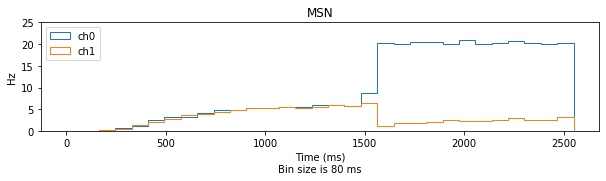

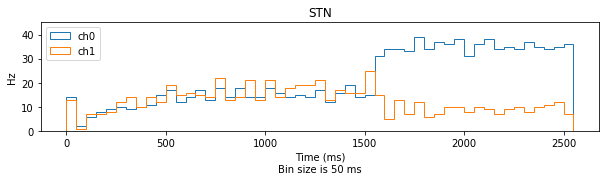

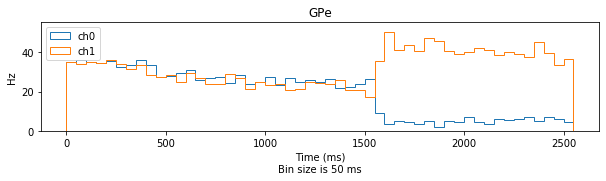

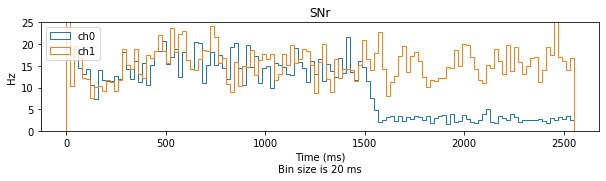

In [3]:
# Plotting results

e = e_normal
plt.rcParams['figure.figsize'] = [10.0, 2.0]
channels = [0,1]
if bg.params.net.msn.is_active: e.bg.plot_activity('msn', channels=channels, time_bin=80, y_range=(0,25)); plt.title('MSN')
if bg.params.net.stn.is_active: plt.figure(); e.bg.plot_activity('stn', channels=channels, y_range=(0,45)); plt.title('STN')
if bg.params.net.gpe.is_active: plt.figure(); e.bg.plot_activity('gpe', channels=channels, y_range=(0,55)); plt.title('GPe')
if bg.params.net.snr.is_active: plt.figure(); e.bg.plot_activity('snr', channels=channels, time_bin=20, y_range=(0,25)); plt.title('SNr')

In [4]:
def rasterplot(
    ax, nucleus_name='snr', channels=0, n_neurons=40, time_bin=50.0, time_axis=False, 
    alpha_spike=0.2, alpha_background=0.125
):
    ax1 = ax
#     ax1.set_title(nucleus_name)
    ax1.set_ylabel(nucleus_name)
    nucleus_name = nucleus_name.lower()

    if type(channels) is not list:
        channels = [channels]
    
    spikes = []
    for i, channel in enumerate(channels):
        # Set background
        ax1.axhspan(i*n_neurons, (i+1)*n_neurons, facecolor=new_colors[i], alpha=alpha_background)
        
        # Plot events        
        detector = bg.__getattribute__('spikedetector_' + nucleus_name + '_channels')[channel]
        senders = nest.GetStatus(detector)[0]['events']['senders']
        times = nest.GetStatus(detector)[0]['events']['times']

        spikes_dict = {sender: [] for sender in senders}
        for sender,time in zip(senders,times):
            spikes_dict[sender].append(time)
        spikes_list = list(spikes_dict.values())
        shuffle(spikes_list)
        spikes += spikes_list[:n_neurons]
    ax1.set_yticks([])
#     ax1.eventplot(spikes, colors='black', alpha=0.4)
    for i, t in enumerate(spikes):
        ax1.plot(t, [i]*len(t), 'o', markersize=1, color='black', alpha=alpha_spike)
    ax1.set_xlim(0,2550)
    ax1.tick_params(labelsize=plt.rcParams['font.size']*0.75)
    if not time_axis: ax1.set_xticks([])
    
    
    ax2 = ax1.twinx()
    for i, channel in enumerate(channels):
        detector = bg.__getattribute__('spikedetector_' + nucleus_name + '_channels')[channel]
        senders = nest.GetStatus(detector)[0]['events']['senders']
        times = nest.GetStatus(detector)[0]['events']['times']

        n_senders = len(set(senders))
        n_bins = int( (max(times)-min(times)) / time_bin)
        
        ax2.hist(
            times,
            bins = n_bins, 
            histtype = 'step', 
            weights = np.ones_like(times) / (n_senders * (time_bin / 1000.0)),
            label = 'ch{}'.format(i),
            linewidth = 2.0,
        )
        ax2.tick_params(labelsize=plt.rcParams['font.size']*0.75)
    
    ax2.axvline(x=1500, linestyle='--', color=new_colors[2])

    
def plot_input_from_cortex(ax):
    time_values = np.linspace(0,2550,num=2550)
    y1 = np.ones_like(time_values)
    y2 = np.ones_like(time_values)
    y1 *= 5
    y2 *= 5
    for i in range(25):
        y1[1500+i] += (i)*2e-2
        y1[1525+i] += (25+i)*2e-2
        y2[1500+i] += (i)*2e-2
        y2[1525+i] += (25-i)*2e-2
    y1[1550:] = 6.0

    ax.plot(time_values, y1)
    ax.plot(time_values, y2)
    ax.set_xlim(0,2550)
    ax.set_ylabel('Ctx')
    ax.yaxis.set_ticks([5, 6])
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks([])
    ax.tick_params(labelsize=plt.rcParams['font.size']*0.75)
    ax.axvline(x=1500, linestyle='--', color=new_colors[2])

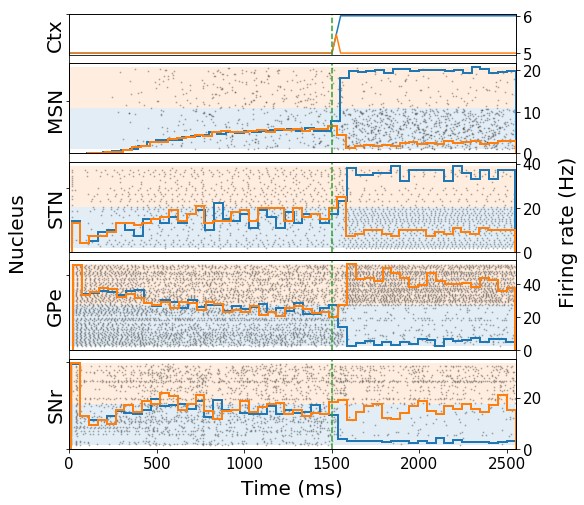

In [5]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]#[6.0, 8.0]
plt.rcParams['font.size'] = 20

fig = plt.figure()
ax_ctx = plt.subplot2grid((9,1), (0,0))
ax_msn = plt.subplot2grid((9,1), (1,0), rowspan=2)
ax_stn = plt.subplot2grid((9,1), (3,0), rowspan=2)
ax_gpe = plt.subplot2grid((9,1), (5,0), rowspan=2)
ax_snr = plt.subplot2grid((9,1), (7,0), rowspan=2)


plot_input_from_cortex(ax_ctx)

rasterplot(ax_msn, 'MSN', channels=[0,1])
rasterplot(ax_stn, 'STN', channels=[0,1], n_neurons=20)
rasterplot(ax_gpe, 'GPe', channels=[0,1])
rasterplot(ax_snr, 'SNr', channels=[0,1], time_axis=True)

ax1 = fig.add_subplot(111, frameon=False)
ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Nucleus')

ax2 = ax1.twinx()
ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax2.set_ylabel('Firing rate (Hz)')
ax2.yaxis.set_label_position('right')

# plt.tight_layout()

plt.savefig("general_behaviour.svg")
plt.savefig("general_behaviour.png", dpi=300, transparent=True)